In [11]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix,
    classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [12]:
_kpi_emp = pd.read_csv("kpi.csv").astype(float)

assert not _kpi_emp.isna().any().any(), "В kpi.csv не должно быть NaN"
assert ((_kpi_emp >= 0) & (_kpi_emp <= 1)).all().all(), "KPI должны быть в [0, 1]"

def generate_kpi_row():
    june      = np.random.choice(_kpi_emp["kpi_june"].values)
    july      = np.random.choice(_kpi_emp["kpi_july"].values)
    august    = np.random.choice(_kpi_emp["kpi_august"].values)
    september = np.random.choice(_kpi_emp["kpi_september"].values)
    october   = np.random.choice(_kpi_emp["kpi_october"].values)

    return [float(june),
            float(july),
            float(august),
            float(september),
            float(october)]


In [13]:
def generate_burnout_data(n, balanced=True):
    mean = 1
    std_dev = 2


    kpi_df = pd.read_csv("kpi.csv")

    kpi_cols = [col for col in kpi_df.columns if col.startswith("kpi_")]
    kpi_df = kpi_df[kpi_cols].astype(float)
    kpi_n = len(kpi_df)

    responses_list = []
    burnout_indices = []
    kpi_list = []

    for i in range(n):
        responses = np.random.normal(mean, std_dev, 22)
        responses = np.clip(np.round(responses), 0, 6).astype(int)

        ee_questions = [0, 1, 2, 7, 12, 13, 15, 19]
        dp_questions = [4, 9, 10, 14, 21]
        pa_questions = [3, 6, 8, 11, 16, 17, 18, 20]

        ee_score = responses[ee_questions].sum()
        dp_score = responses[dp_questions].sum()
        ee_score += (6 - responses[5])
        pa_score = responses[pa_questions].sum()

        burnout_index = np.sqrt(
            ((ee_score / 54) ** 2 +
             (dp_score / 30) ** 2 +
             ((1 - pa_score / 48)) ** 2) / 3
        )

        responses_list.append(responses)
        burnout_indices.append(burnout_index)

        if i < kpi_n:
            kpi_row = kpi_df.iloc[i].values
        else:
            rand_idx = np.random.randint(0, kpi_n)
            kpi_row = kpi_df.iloc[rand_idx].values

        kpi_list.append(kpi_row)

    burnout_indices = np.array(burnout_indices)
    kpi_array = np.array(kpi_list)

    if not balanced:
        labels = []
        for bi in burnout_indices:
            if bi >= 0.55:
                label = 2
            elif bi >= 0.45 and bi < 0.55:
                label = 1
            else:
                label = 0
            labels.append(label)
        labels = np.array(labels)
    else:
        order = np.argsort(burnout_indices)
        labels = np.empty(n, dtype=int)

        n0 = n // 3
        n1 = 2 * n // 3

        labels[order[:n0]] = 0
        labels[order[n0:n1]] = 1
        labels[order[n1:]] = 2

    rows = []
    for i in range(n):
        row = (
            list(responses_list[i]) +
            list(kpi_array[i]) +
            [burnout_indices[i], labels[i]]
        )
        rows.append(row)

    columns = (
        [f'Q{i+1}' for i in range(22)] +
        kpi_cols +
        ['burnout_index', 'label']
    )

    df = pd.DataFrame(rows, columns=columns)
    return df


In [14]:
np.random.seed(42) 
n = 100000
df = generate_burnout_data(n, balanced=True)

df.to_csv('burnout_test_data.csv', index=False, encoding='utf-8')
print(df.head())

   Q1  Q2  Q3  Q4  Q5  Q6  Q7  Q8  Q9  Q10  ...  Q20  Q21  Q22  kpi_june  \
0   2   1   2   4   1   1   4   3   0    2  ...    0    4    1      1.00   
1   1   0   0   1   0   2   0   0   0    5  ...    1    1    0      0.75   
2   0   0   0   3   2   0   2   0   0    2  ...    0    3    4      1.00   
3   1   3   2   0   2   4   1   4   0    3  ...    0    3    2      1.00   
4   0   2   1   3   0   0   0   0   2    2  ...    1    2    1      1.00   

   kpi_july  kpi_august  kpi_september  kpi_october  burnout_index  label  
0      0.96         0.8            0.9         0.90       0.442240      0  
1      0.60         1.0            1.0         0.80       0.543059      2  
2      0.75         0.8            0.8         0.95       0.509266      1  
3      1.00         1.0            1.0         1.00       0.535912      2  
4      0.80         1.0            1.0         0.90       0.406823      0  

[5 rows x 29 columns]


In [15]:
def load_and_prepare_data(filename):
    df = pd.read_csv(filename)

    X = df.drop(columns=['label'])
    y = df['label']

    feature_names = X.columns.tolist()

    print(f"Размерность данных (X): {X.shape}")
    print("Распределение классов:")
    class_counts = y.value_counts().sort_index()
    for cls, cnt in class_counts.items():
        print(f"  Класс {cls}: {cnt} ({cnt / len(y):.2%})")

    any_burnout = (y > 0).mean()
    strong_burnout = (y == 2).mean()
    print(f"Процент любого выгорания (1 или 2): {any_burnout:.2%}")
    print(f"Процент сильного выгорания (2): {strong_burnout:.2%}")

    if 'burnout_index' in df.columns:
        metric = df['burnout_index']
        print("\nИНТЕГРАЛЬНАЯ МЕТРИКА (burnout_index):")
        print(f"  Среднее: {metric.mean():.4f}")
        print(f"  Минимум: {metric.min():.4f}")
        print(f"  Максимум: {metric.max():.4f}")

    kpi_cols = [c for c in df.columns if c.startswith('kpi_')]
    if kpi_cols:
        print("\nKPI по месяцам:")
        kpi_summary = df[kpi_cols].describe().loc[['mean', 'min', 'max']]
        print(kpi_summary.to_string())

    return X, y, feature_names

In [16]:
def train_and_evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = LogisticRegression(
        random_state=2025,
        max_iter=200,
        class_weight='balanced',
        multi_class='multinomial',
        solver='lbfgs'
    )
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    return model, scaler, X_test, y_test, y_pred, y_pred_proba

In [17]:
def plot_metrics(y_test, y_pred, y_pred_proba, model, feature_names):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
    axes[0, 0].set_title('Матрица ошибок')
    axes[0, 0].set_xlabel('Предсказанный класс')
    axes[0, 0].set_ylabel('Истинный класс')

    if 2 in model.classes_:
        idx_high = list(model.classes_).index(2)
        y_test_high = (y_test == 2).astype(int)
        y_proba_high = y_pred_proba[:, idx_high]

        fpr, tpr, _ = roc_curve(y_test_high, y_proba_high)
        roc_auc_high = roc_auc_score(y_test_high, y_proba_high)

        axes[0, 1].plot(fpr, tpr, lw=2,
                        label=f'ROC (AUC = {roc_auc_high:.3f})')
        axes[0, 1].plot([0, 1], [0, 1], lw=2, linestyle='--')
        axes[0, 1].set_xlim([0.0, 1.0])
        axes[0, 1].set_ylim([0.0, 1.05])
        axes[0, 1].set_xlabel('False Positive Rate')
        axes[0, 1].set_ylabel('True Positive Rate')
        axes[0, 1].set_title('ROC-кривая для сильного выгорания (класс 2)')
        axes[0, 1].legend(loc="lower right")
    else:
        axes[0, 1].text(
            0.5, 0.5,
            'Класс 2 отсутствует\nROC-кривая не построена',
            ha='center', va='center'
        )
        axes[0, 1].set_axis_off()

    coefs = model.coef_
    feature_importance = np.mean(np.abs(coefs), axis=0)

    n_features = feature_importance.shape[0]
    assert n_features == len(feature_names), "Размерность признаков не совпала."

    feature_types = []
    for name in feature_names:
        if name.startswith('Q'):
            feature_types.append('Вопрос')
        elif name.startswith('kpi_'):
            feature_types.append('KPI')
        elif name == 'burnout_index':
            feature_types.append('Индекс')
        else:
            feature_types.append('Признак')

    indices = np.argsort(feature_importance)[::-1]

    if len(indices) > 0:
        indices_wo_top = indices[1:]
    else:
        indices_wo_top = indices

    bar_heights = feature_importance[indices_wo_top]
    bar_labels = [feature_names[i] for i in indices_wo_top]
    bar_types  = [feature_types[i] for i in indices_wo_top]

    colors_map = {'Вопрос': 'tab:blue', 'KPI': 'tab:orange', 'Индекс': 'tab:green', 'Признак': 'tab:gray'}
    bar_colors = [colors_map.get(t, 'tab:gray') for t in bar_types]

    ax_imp = axes[1, 0]
    ax_imp.bar(range(len(bar_heights)), bar_heights, color=bar_colors)
    ax_imp.set_title('Важность признаков (без самого доминирующего)')
    ax_imp.set_xlabel('Признаки')
    ax_imp.set_ylabel('Среднее |коэфф.| по классам')
    ax_imp.set_xticks(range(len(bar_heights)))
    ax_imp.set_xticklabels(bar_labels, rotation=45, ha='right')

    handles = []
    for t, c in colors_map.items():
        if t in bar_types:
            handles.append(plt.Line2D([0], [0], marker='s', linestyle='',
                                      color=c, label=t))
    if handles:
        ax_imp.legend(handles=handles, title="Тип признака")

    ax_hist = axes[1, 1]
    if 2 in model.classes_:
        idx_high = list(model.classes_).index(2)
        y_test_high = (y_test == 2).astype(int)
        y_proba_high = y_pred_proba[:, idx_high]

        ax_hist.hist(
            [y_proba_high[y_test_high == 0],
             y_proba_high[y_test_high == 1]],
            bins=20, alpha=0.7,
            label=['Нет сильного выгорания (0 или 1)',
                   'Сильное выгорание (2)']
        )
        ax_hist.set_title('Распределение P(класс 2)')
        ax_hist.set_xlabel('Вероятность сильного выгорания')
        ax_hist.set_ylabel('Частота')
        ax_hist.legend()
    else:
        ax_hist.text(
            0.5, 0.5,
            'Класс 2 отсутствует\nгистограмма не построена',
            ha='center', va='center'
        )
        ax_hist.set_axis_off()

    plt.tight_layout()
    plt.show()


Размерность данных (X): (100000, 28)
Распределение классов:
  Класс 0: 33333 (33.33%)
  Класс 1: 33333 (33.33%)
  Класс 2: 33334 (33.33%)
Процент любого выгорания (1 или 2): 66.67%
Процент сильного выгорания (2): 33.33%

ИНТЕГРАЛЬНАЯ МЕТРИКА (burnout_index):
  Среднее: 0.4994
  Минимум: 0.2390
  Максимум: 0.7199

KPI по месяцам:
      kpi_june  kpi_july  kpi_august  kpi_september  kpi_october
mean  0.933644  0.896292    0.930642        0.92804     0.938012
min   0.710000  0.600000    0.760000        0.67000     0.600000
max   1.000000  1.000000    1.000000        1.00000     1.000000

Обучение модели...


/opt/venvs/seaborn-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



МЕТРИКИ МОДЕЛИ (3 класса)
Точность (Accuracy): 0.9947
Точность (Precision, weighted): 0.9947
Полнота (Recall, weighted): 0.9947
F1-мера (weighted): 0.9947
ROC-AUC для сильного выгорания (класс 2): 1.0000

ОТЧЕТ КЛАССИФИКАЦИИ
                         precision    recall  f1-score   support

      Нет выгорания (0)       0.99      1.00      1.00      6667
Умеренное выгорание (1)       0.99      0.99      0.99      6666
  Сильное выгорание (2)       1.00      0.99      1.00      6667

               accuracy                           0.99     20000
              macro avg       0.99      0.99      0.99     20000
           weighted avg       0.99      0.99      0.99     20000


Визуализация метрик...


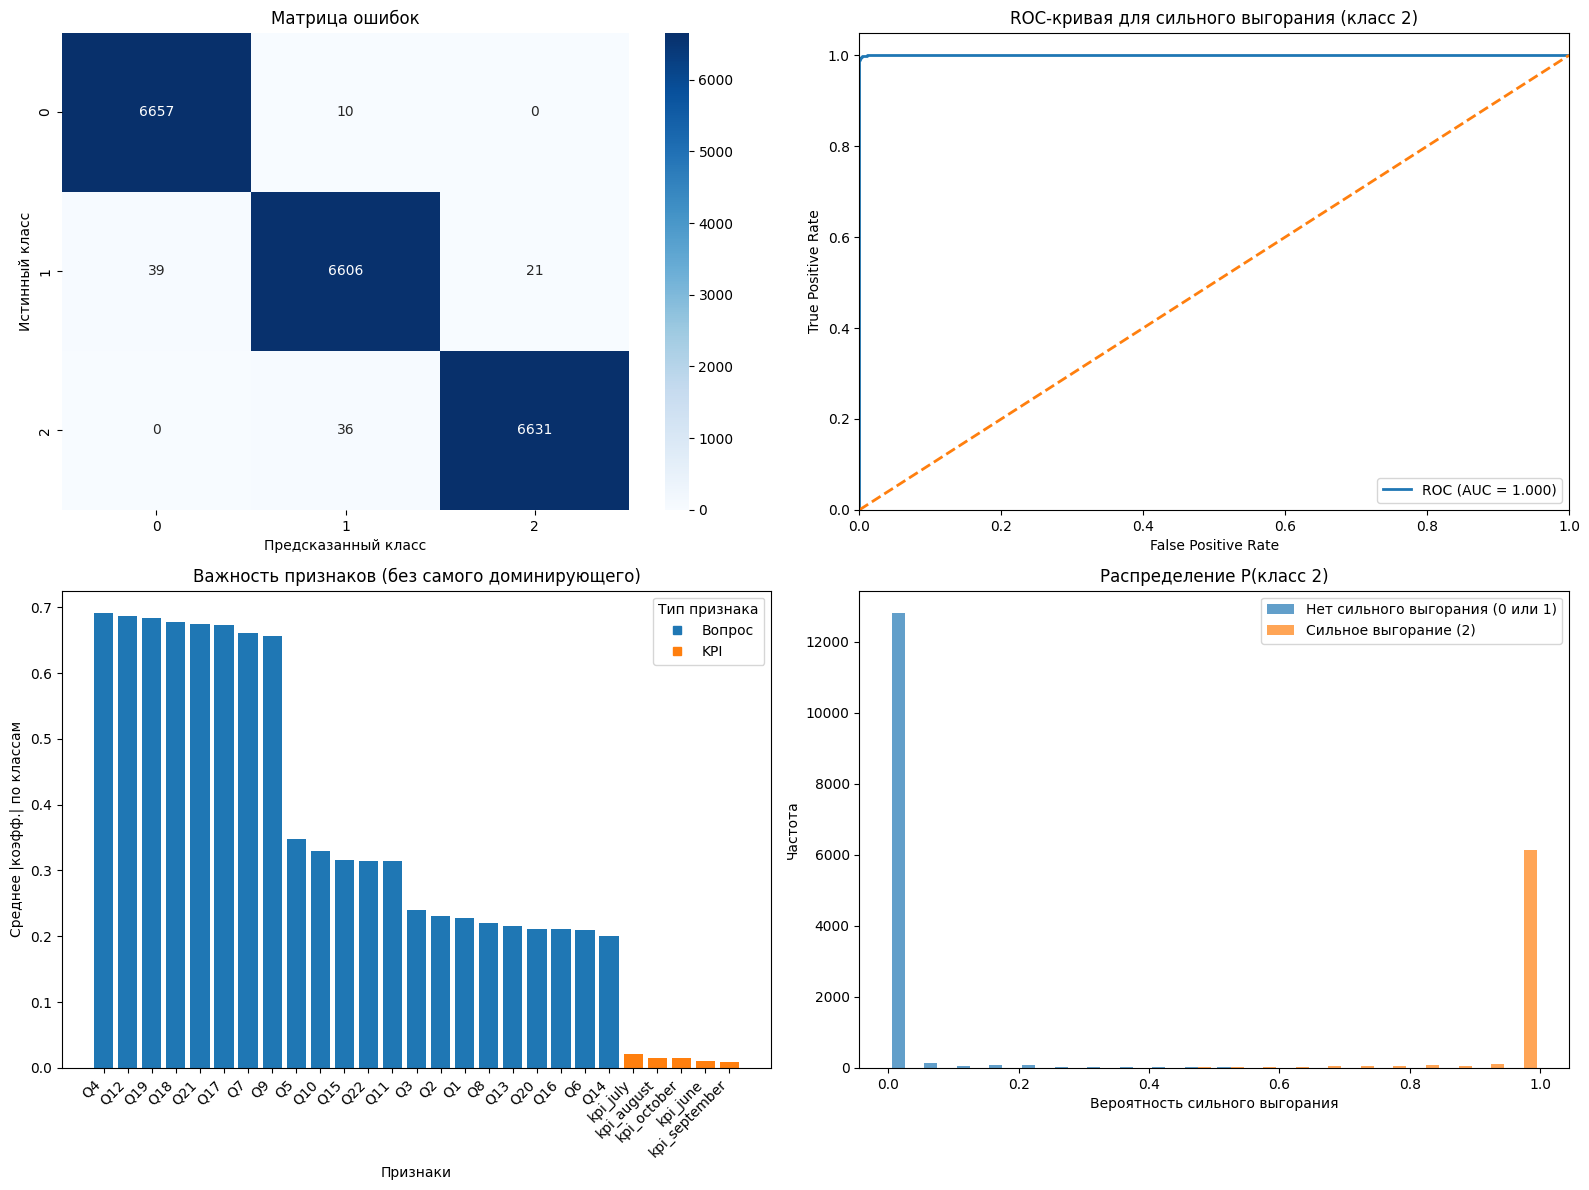


ТОП-10 важных признаков
Признак    Тип  Важность
     Q4 Вопрос  0.690705
    Q12 Вопрос  0.686663
    Q19 Вопрос  0.684297
    Q18 Вопрос  0.677675
    Q21 Вопрос  0.674575
    Q17 Вопрос  0.673153
     Q7 Вопрос  0.660733
     Q9 Вопрос  0.656591
     Q5 Вопрос  0.347108
    Q10 Вопрос  0.328972

Модель и скейлер сохранены в 'burnout_model.pkl' и 'burnout_scaler.pkl'.


In [20]:
def main():
    X, y, feature_names = load_and_prepare_data('burnout_test_data.csv')
    print("\nОбучение модели...")
    model, scaler, X_test, y_test, y_pred, y_pred_proba = train_and_evaluate_model(X, y)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print("\n" + "="*50)
    print("МЕТРИКИ МОДЕЛИ (3 класса)")
    print("="*50)
    print(f"Точность (Accuracy): {accuracy:.4f}")
    print(f"Точность (Precision, weighted): {precision:.4f}")
    print(f"Полнота (Recall, weighted): {recall:.4f}")
    print(f"F1-мера (weighted): {f1:.4f}")

    if 2 in model.classes_:
        idx_high = list(model.classes_).index(2)
        y_test_high = (y_test == 2).astype(int)
        y_proba_high = y_pred_proba[:, idx_high]
        roc_auc_high = roc_auc_score(y_test_high, y_proba_high)
        print(f"ROC-AUC для сильного выгорания (класс 2): {roc_auc_high:.4f}")
    else:
        print("ROC-AUC: класс 2 не встречался в тесте, метрику посчитать нельзя.")

    print("\n" + "="*50)
    print("ОТЧЕТ КЛАССИФИКАЦИИ")
    print("="*50)
    print(classification_report(
        y_test, y_pred,
        labels=[0, 1, 2],
        target_names=[
            'Нет выгорания (0)',
            'Умеренное выгорание (1)',
            'Сильное выгорание (2)'
        ],
        zero_division=0
    ))

    print("\nВизуализация метрик...")
    plot_metrics(y_test, y_pred, y_pred_proba, model, feature_names)

    print("\n" + "="*50)
    print("ТОП-10 важных признаков")
    print("="*50)

    coefs = model.coef_
    feature_importance = np.mean(np.abs(coefs), axis=0)

    feature_types = []
    for name in feature_names:
        if name.startswith('Q'):
            feature_types.append('Вопрос')
        elif name.startswith('kpi_'):
            feature_types.append('KPI')
        elif name == 'burnout_index':
            feature_types.append('Индекс')
        else:
            feature_types.append('Признак')

    importance_df = pd.DataFrame({
        'Признак': feature_names,
        'Тип': feature_types,
        'Важность': feature_importance,
    }).sort_values('Важность', ascending=False)

    importance_df_wo_top = importance_df.iloc[1:]
    print(importance_df_wo_top.head(10).to_string(index=False))
    
    joblib.dump(model, 'burnout_model.pkl')
    joblib.dump(scaler, 'burnout_scaler.pkl')
    print("\nМодель и скейлер сохранены в 'burnout_model.pkl' и 'burnout_scaler.pkl'.")
    

if __name__ == "__main__":
    main()